<a href="https://colab.research.google.com/github/kodegut/SwiftForTensorFlow/blob/main/IrisFlowerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Iris Flower Classification with Swift
## Ongoing traning project...
A classic dataset when approaching TensorFlow or machine learning in general is the iris_training set.
You can find a detailed description in this walkthrough, which also serves as the basis for this notebooks content:

https://colab.research.google.com/github/tensorflow/swift/blob/main/docs/site/tutorials/model_training_walkthrough.ipynb 

**In short:** We are trying to classify iris flowers based on the measurements of their sepals (Kelchblätter) and petals (Blütenblätter) and this time we do it with Swift.

In [67]:
import TensorFlow

// Swift framework to interact with Python:
import PythonKit

In [68]:
// This cell is here to display the plots in a Jupyter Notebook.
// Do not copy it into another environment.
%include "EnableIPythonDisplay.swift"
print(IPythonDisplay.shell.enable_matplotlib("inline"))

('inline', 'module://ipykernel.pylab.backend_inline')


In [69]:
let plt = Python.import("matplotlib.pyplot")

In [70]:
import Foundation
import FoundationNetworking

func download(from sourceString: String, to destinationString: String) {
    let source = URL(string: sourceString)!
    let destination = URL(fileURLWithPath: destinationString)
    let data = try! Data.init(contentsOf: source)
    try! data.write(to: destination)
}

In [71]:
let trainDataFilename = "iris_training.csv"
download(from: "http://download.tensorflow.org/data/iris_training.csv", to: trainDataFilename)

In [72]:
let featureNames = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
let labelName = "species"
let columnNames = featureNames + [labelName]
let classNames = ["Iris setosa", "Iris versicolor", "Iris virginica"]

print("Features: \(featureNames)")
print("Label: \(labelName)")

Features: ["sepal_length", "sepal_width", "petal_length", "petal_width"]
Label: species


In [73]:
let batchSize = 32

/// A batch of examples from the iris dataset.
struct IrisBatch {
    /// [batchSize, featureCount] tensor of features.
    let features: Tensor<Float>

    /// [batchSize] tensor of labels.
    let labels: Tensor<Int32>
}

/// Conform `IrisBatch` to `Collatable` so that we can load it into a `TrainingEpoch`.
extension IrisBatch: Collatable {
    public init<BatchSamples: Collection>(collating samples: BatchSamples)
        where BatchSamples.Element == Self {
        /// `IrisBatch`es are collated by stacking their feature and label tensors
        /// along the batch axis to produce a single feature and label tensor
        features = Tensor<Float>(stacking: samples.map{$0.features})
        labels = Tensor<Int32>(stacking: samples.map{$0.labels})
    }
}

In [74]:
/// Initialize an `IrisBatch` dataset from a CSV file.
func loadIrisDatasetFromCSV(
        contentsOf: String, hasHeader: Bool, featureColumns: [Int], labelColumns: [Int]) -> [IrisBatch] {
        let np = Python.import("numpy")

        let featuresNp = np.loadtxt(
            contentsOf,
            delimiter: ",",
            skiprows: hasHeader ? 1 : 0,
            usecols: featureColumns,
            dtype: Float.numpyScalarTypes.first!)
        guard let featuresTensor = Tensor<Float>(numpy: featuresNp) else {
            // This should never happen, because we construct featuresNp in such a
            // way that it should be convertible to tensor.
            fatalError("np.loadtxt result can't be converted to Tensor")
        }

        let labelsNp = np.loadtxt(
            contentsOf,
            delimiter: ",",
            skiprows: hasHeader ? 1 : 0,
            usecols: labelColumns,
            dtype: Int32.numpyScalarTypes.first!)
        guard let labelsTensor = Tensor<Int32>(numpy: labelsNp) else {
            // This should never happen, because we construct labelsNp in such a
            // way that it should be convertible to tensor.
            fatalError("np.loadtxt result can't be converted to Tensor")
        }

        return zip(featuresTensor.unstacked(), labelsTensor.unstacked()).map{IrisBatch(features: $0.0, labels: $0.1)}

    }

In [75]:
let trainingDataset: [IrisBatch] = loadIrisDatasetFromCSV(contentsOf: trainDataFilename, 
                                                  hasHeader: true, 
                                                  featureColumns: [0, 1, 2, 3], 
                                                  labelColumns: [4])

let trainingEpochs: TrainingEpochs = TrainingEpochs(samples: trainingDataset, batchSize: batchSize)

In [76]:
let firstTrainEpoch = trainingEpochs.next()!
let firstTrainBatch = firstTrainEpoch.first!.collated
let firstTrainFeatures = firstTrainBatch.features
let firstTrainLabels = firstTrainBatch.labels

//print("First batch of features: \(firstTrainFeatures)")
//print("firstTrainFeatures.shape: \(firstTrainFeatures.shape)")
//print("First batch of labels: \(firstTrainLabels)")
//print("firstTrainLabels.shape: \(firstTrainLabels.shape)")

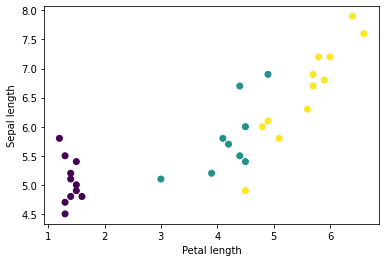

Use `print()` to show values.


In [77]:
let firstTrainFeaturesTransposed = firstTrainFeatures.transposed()
let petalLengths = firstTrainFeaturesTransposed[2].scalars
let sepalLengths = firstTrainFeaturesTransposed[0].scalars

plt.scatter(petalLengths, sepalLengths, c: firstTrainLabels.array.scalars)
plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

In [78]:
let hiddenSize: Int = 10
struct IrisModel: Layer {
    var layer1 = Dense<Float>(inputSize: 4, outputSize: hiddenSize, activation: relu)
    var layer2 = Dense<Float>(inputSize: hiddenSize, outputSize: hiddenSize, activation: relu)
    var layer3 = Dense<Float>(inputSize: hiddenSize, outputSize: 3)
    
    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        return input.sequenced(through: layer1, layer2, layer3)
    }
}

var model = IrisModel()